In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pyproj
import osmnx
import shapely
from geopy import distance
import seaborn as sns

In [2]:
DaytonDf=pd.read_csv("13/Dayton.csv")
roadNetwork=osmnx.io.load_graphml("data/road.graphml")
study_area = osmnx.geocode_to_gdf("Dayton")

In [3]:
DaytonDf.columns

Index(['Unnamed: 0', 'ID', 'Source', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Street', 'City', 'County', 'State', 'Zipcode',
       'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [5]:
nodes, edges=osmnx.graph_to_gdfs(roadNetwork)

In [46]:
DaytonDf["start_coordinate"]=DaytonDf.apply(
    lambda x: shapely.Point(x["Start_Lng"], x["Start_Lat"]), axis=1)

In [51]:
edges['buffered_geometry'] = edges.copy()['geometry'].apply(lambda geom: geom.buffer(0.1))

In [55]:
edges["accident_count"]= edges.apply(
    lambda x: len(DaytonDf[x['buffered_geometry'].intersects(DaytonDf["start_coordinate"])]
                ),  axis=1
)

In [34]:
edges["accident_count"].value_counts

<bound method IndexOpsMixin.value_counts of u            v            key
198817433    198846074    0      0
             198817442    0      0
             199047720    0      0
198817442    198872321    0      0
             198892095    0      0
                                ..
12710989821  12710989820  0      0
12710991934  198969473    0      0
             198872889    0      0
             198872925    0      0
             198969497    0      0
Name: accident_count, Length: 14804, dtype: int64>

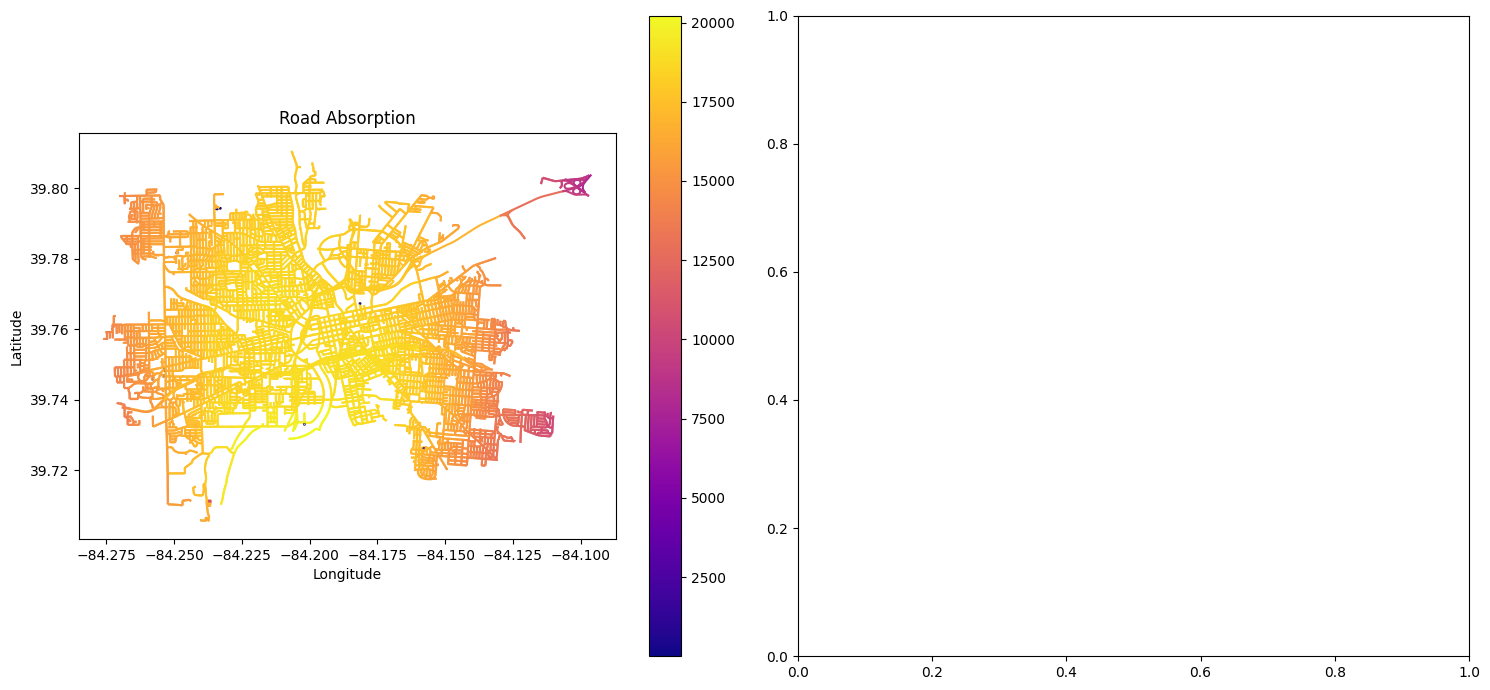

In [56]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot absorption
edges.plot(column='accident_count', cmap='plasma', legend=True, ax=axes[0])
axes[0].set_title('Road Absorption')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

plt.tight_layout()
plt.show()